First, let's install and import the necessary packages

In [ ]:
!pip3 install dataframe_image
!pip3 install selenium
!sudo apt install firefox

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
from sklearn.model_selection import train_test_split
import warnings

As well as load data from git repository

In [ ]:
!git clone https://github.com/eg0rzuev/ml-titanic-predictions.git

Create the test, train datasets

In [ ]:
titanic_df = pd.read_csv('./ml-titanic-predictions/titanic/titanic.csv')

# Split the dataset into training and testing sets
train, test = train_test_split(titanic_df, test_size=0.3, random_state=42)

dfi.export(train.head(), './ml-titanic-predictions/images/train_head.png', table_conversion='selenium')
train.head()

,name,gender,age,class,embarked,country,ticketno,fare,sibsp,parch,survived
1711,"Ingrouille, Mr. Henry",male,21.0,victualling crew,S,England,NaN,NaN,NaN,NaN,no
1502,"Cox, Mr. William Denton",male,30.0,victualling crew,S,England,NaN,NaN,NaN,NaN,no
292,"Dakic, Mr. Branko",male,19.0,3rd,S,NaN,349228.0,10.0305,0.0,0.0,no
905,"Oliva y Ocana, Doña. Fermina",female,39.0,1st,C,Spain,17758.0,108.1800,0.0,0.0,yes
1107,"Silvey, Mr. William Baird",male,51.0,1st,C,United States,13507.0,55.1800,1.0,0.0,no


Drop these columns since they don't provide any useful information for the model. 'Country' coulumn has too many different values, if I leave it there the dataset will become sparce

In [ ]:
train.drop(['name', 'ticketno','country'], axis = 1, inplace = True)
test.drop(['name', 'ticketno','country'], axis = 1, inplace = True)

Describe the numeric data

In [ ]:
dfi.export(train.describe(), './ml-titanic-predictions/images/train_describe.png', table_conversion='selenium')
train.describe()

,age,fare,sibsp,parch
count,1542.000000,901.000000,910.000000,910.000000
mean,30.684122,33.143496,0.484615,0.387912
std,12.165124,52.276573,1.048486,0.901085
min,0.416667,4.000000,0.000000,0.000000
25%,22.000000,7.180600,0.000000,0.000000
50%,29.000000,14.090100,0.000000,0.000000
75%,38.000000,31.050600,1.000000,0.000000
max,72.000000,512.060700,8.000000,9.000000


Transform this column for a simplier code writing

In [ ]:
train['survived'] = [True if survived == 'yes' else False for survived in train['survived']]
test['survived'] = [True if survived == 'yes' else False for survived in test['survived']]

Transform data for a more detailed plot

In [ ]:
#string values are not displayed at a pairplot
train.gender = [0 if person == 'female' else 1 for person in train.gender]
test.gender = [0 if person == 'female' else 1 for person in test.gender]

Pairplot data visualisation

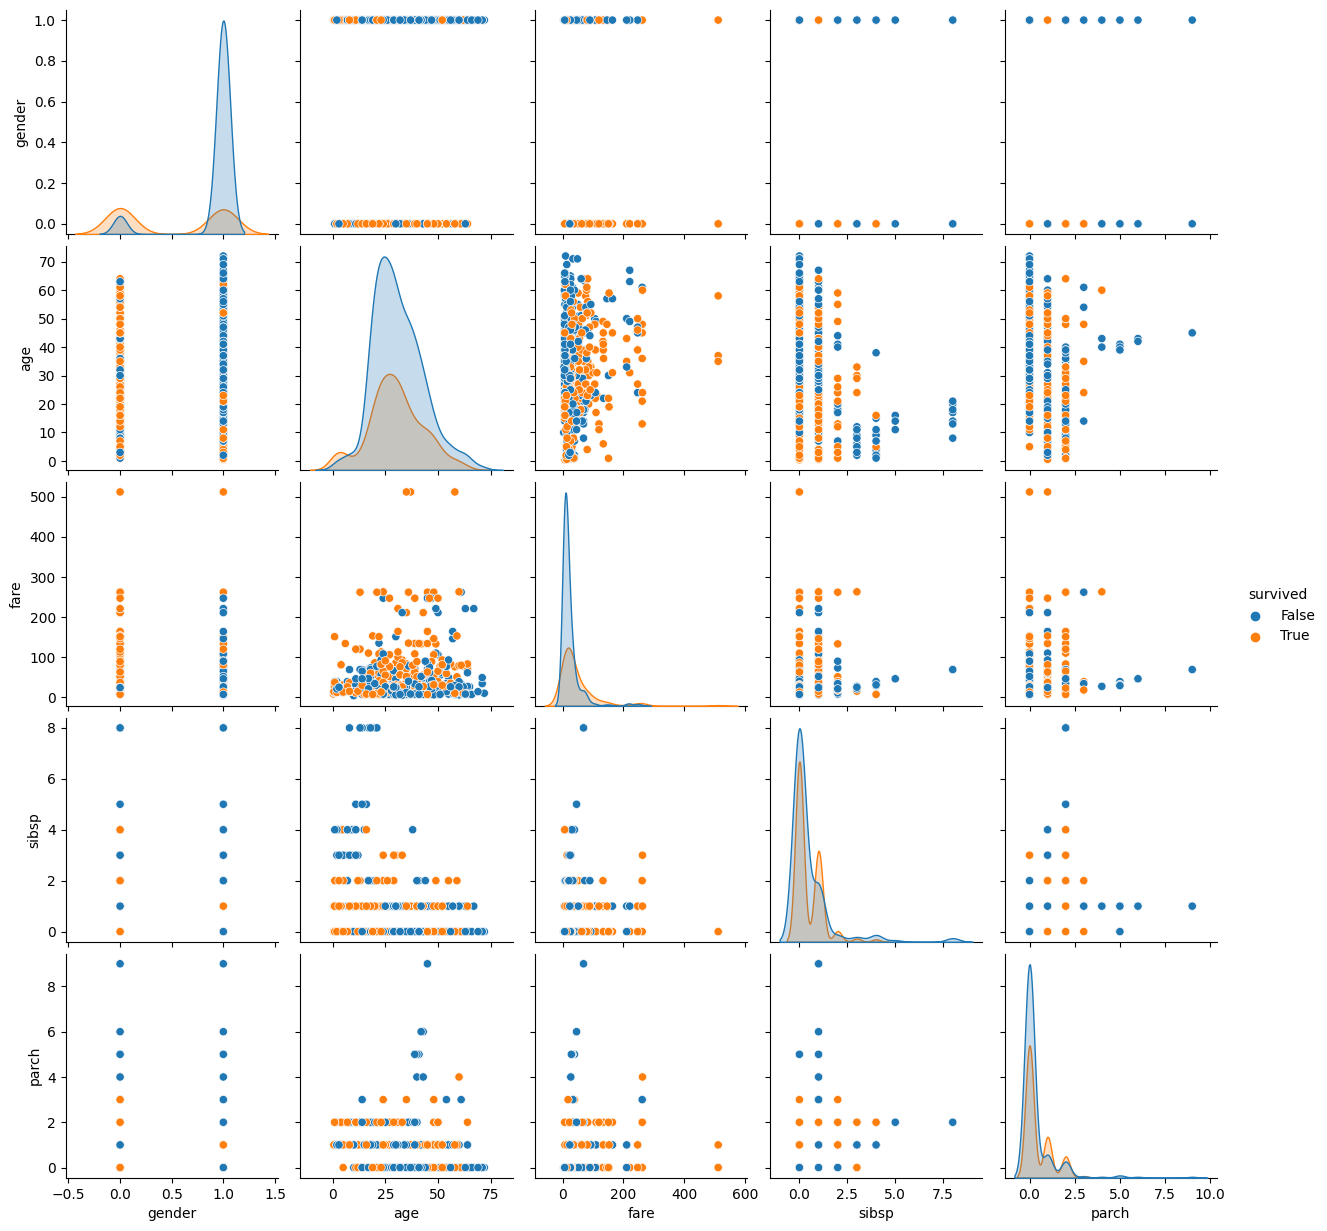

In [ ]:
sns.pairplot(train, hue='survived')

Imoirting the ML libraries

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import FitFailedWarning

random_state=42

Initial preprocessing:
- place 'survived' column into `train_target`
- filling empty values with a mean value
- the categorical features are processed using OneHotEncoder, numerical values are transformed with StandardScaler

In [ ]:
train_target = train.survived
train.drop(['survived'], inplace=True, axis=1)
train = train.fillna(train.mean())
test = test.fillna(train.mean())

<ipython-input-34-44aef81195b0>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train = train.fillna(train.mean())
<ipython-input-34-44aef81195b0>:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test = test.fillna(train.mean())


In [ ]:
categorical_data_columns = train.select_dtypes(include='object').columns
numeric_data_columns = train.select_dtypes(include=['float', 'int']).columns

column_transformer = ColumnTransformer([('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_data_columns),
    ('numerical', StandardScaler(), numeric_data_columns)])
train_data = column_transformer.fit_transform(train)
test_data = column_transformer.transform(test)

Perform PCA and visualize the results

In [ ]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(test_data)
pca_df = pd.DataFrame(data = principal_components, columns = ['component1', 'component2'])
pca_df = pd.concat([pca_df, train_target], axis = 1)

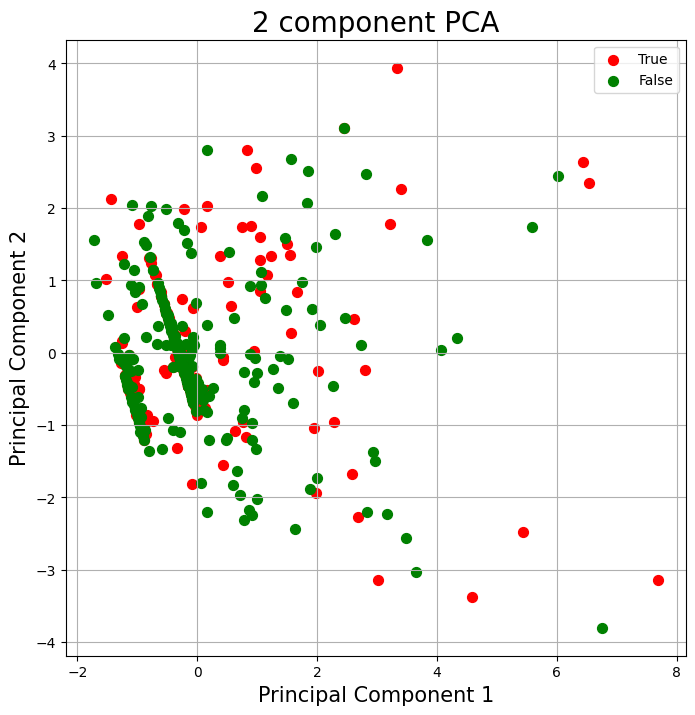

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [True, False]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['survived'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'component1']
               , pca_df.loc[indicesToKeep, 'component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
def evaluate(model, test_data = test_data):
    print(model.best_score_)
    print(model.best_params_)
    print()
    predict = model.predict(test_data)
    test_predictions = model.predict(test_data)
    tn, fp, fn, tp = confusion_matrix([bool(x) for x in test['survived']], test_predictions).ravel()

    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = fp / (fp + tn)
    fnr = fn / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)

    print("True Positive Rate (TPR):", tpr)
    print("True Negative Rate (TNR):", tnr)
    print("False Positive Rate (FPR):", fpr)
    print("False Negative Rate (FNR):", fnr)

    print()

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)

    #submission  = pd.read_csv('./ml-titanic-predictions/titanic/gender_submission.csv')
    #submission.Survived = predict=
    #submission.to_csv('./ml-titanic-predictions/titanic/submision.csv',  index=False)

In [ ]:
knn_model = KNeighborsClassifier()
param_frid = {
    'n_neighbors': np.arange(1, 30),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan','chebyshev'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']}
grid_search = GridSearchCV(knn_model, param_frid, verbose=True, n_jobs=-1)
grid_search.fit(train_data, train_target)
#dfi.export(train.head(), './ml-titanic-predictions/images/train_head.png', table_conversion='selenium')
#train.head()
evaluate(grid_search)

Fitting 5 folds for each of 522 candidates, totalling 2610 fits
0.8069957550540074
{'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
True Positive Rate (TPR): 0.5813953488372093
True Negative Rate (TNR): 0.8683035714285714
False Positive Rate (FPR): 0.13169642857142858
False Negative Rate (FNR): 0.4186046511627907

Accuracy: 0.77526395173454
Precision: 0.6793478260869565
Recall: 0.5813953488372093
F1 Score: 0.6265664160401002


In [ ]:
log_reg = LogisticRegression()
param_grid = {
    'C': np.logspace(-4, 4, 20),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': [None, 'balanced'],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'l1_ratio': np.arange(0.1, 0.9, 0.05)
}
grid_search = GridSearchCV(log_reg, param_grid, verbose=True, n_jobs=-1)
grid_search.fit(train_data, train_target)

In [ ]:
evaluate(grid_search)

0.8076409027865339
{'C': 1.623776739188721, 'class_weight': None, 'l1_ratio': 0.30000000000000004, 'penalty': 'elasticnet', 'solver': 'saga'}
True Positive Rate (TPR): 0.5534883720930233
True Negative Rate (TNR): 0.8727678571428571
False Positive Rate (FPR): 0.12723214285714285
False Negative Rate (FNR): 0.44651162790697674

Accuracy: 0.7692307692307693
Precision: 0.6761363636363636
Recall: 0.5534883720930233
F1 Score: 0.608695652173913


In [ ]:
tree = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['random', 'best'],
    'min_samples_split': np.arange(2, 15),
    'class_weight': ['balanced', None, {1: 0.38, 0: 0.62}],
    'ccp_alpha': np.arange(0, 0.9, 0.1),

}
grid_search = GridSearchCV(tree, param_grid, verbose=True, n_jobs=-1)
grid_search.fit(train_data, train_target)
evaluate(grid_search)

Fitting 5 folds for each of 1404 candidates, totalling 7020 fits
0.7966439709158156
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'min_samples_split': 11, 'splitter': 'random'}
True Positive Rate (TPR): 0.5302325581395348
True Negative Rate (TNR): 0.8683035714285714
False Positive Rate (FPR): 0.13169642857142858
False Negative Rate (FNR): 0.4697674418604651

Accuracy: 0.7586726998491704
Precision: 0.6589595375722543
Recall: 0.5302325581395348
F1 Score: 0.5876288659793815


In [ ]:
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)
#there are warnings for the cases when bootstrap =
forest = RandomForestClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'n_estimators': np.arange(10, 150, 10),
    'bootstrap': [True, False],
    'max_samples': np.arange(0.1, 1.0, 0.1),
}
grid_search = GridSearchCV(forest, param_grid, verbose=True, n_jobs=-1)
grid_search.fit(train_data, train_target)
evaluate(grid_search)

Fitting 5 folds for each of 1512 candidates, totalling 7560 fits
0.8115328037658134
{'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_samples': 0.2, 'n_estimators': 70}
True Positive Rate (TPR): 0.5395348837209303
True Negative Rate (TNR): 0.8683035714285714
False Positive Rate (FPR): 0.13169642857142858
False Negative Rate (FNR): 0.4604651162790698

Accuracy: 0.7616892911010558
Precision: 0.6628571428571428
Recall: 0.5395348837209303
F1 Score: 0.5948717948717948


In [ ]:
boosting = GradientBoostingClassifier()
param_grid = {
    'loss': ['log_loss', 'exponential'],
    'n_estimators': np.arange(10, 150, 10),
    'subsample': np.arange(0.1, 1.0, 0.1),
    'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae']
}
grid_search = GridSearchCV(boosting, param_grid, verbose=3, n_jobs=-1)
grid_search.fit(train_data, train_target)
evaluate(grid_search)

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


0.8180010927583743
{'criterion': 'squared_error', 'loss': 'deviance', 'n_estimators': 130, 'subsample': 0.8}
True Positive Rate (TPR): 0.5674418604651162
True Negative Rate (TNR): 0.9017857142857143
False Positive Rate (FPR): 0.09821428571428571
False Negative Rate (FNR): 0.4325581395348837

Accuracy: 0.7933634992458521
Precision: 0.7349397590361446
Recall: 0.5674418604651162
F1 Score: 0.6404199475065616


In [ ]:
mlp_model = MLPClassifier()

# Define the hyperparameters for grid search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50,), (100,100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# Create the grid search object
grid_search = GridSearchCV(mlp_model, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search object to the data
grid_search.fit(train_data, train_target)
evaluate(grid_search)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
0.818650443407725
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
True Positive Rate (TPR): 0.5627906976744186
True Negative Rate (TNR): 0.8683035714285714
False Positive Rate (FPR): 0.13169642857142858
False Negative Rate (FNR): 0.4372093023255814

Accuracy: 0.7692307692307693
Precision: 0.6722222222222223
Recall: 0.5627906976744186
F1 Score: 0.6126582278481013
